In [1]:
import pandas
df = pandas.read_csv("loan_data_cleaned.csv", sep='\t', encoding='utf-8', )

In [2]:
for k in df.keys():
    if df[k].max() > 1.5:
        df[k] = (df[k] - df[k].mean())/df[k].std()

In [22]:
from sklearn.cross_validation import train_test_split
df['not_default'] = 1 - df['default']
Xs = df.drop(columns=['default', 'not_default']).values
Ys = df[['default', 'not_default']].values*[5,1]
# Ys = df[['default']].values
# Xs = (Xs - Xs.mean())/Xs.std(axis=0)  # Normalize
X_train, X_test, Y_train, Y_test = train_test_split(Xs, Ys, test_size=0.3, random_state=0)
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)
# X_d = X_train[Y_train[:, 0] == 1]
# X_n = X_train[Y_train[:, 1] == 1]
# Y_d = Y_train[Y_train[:, 0] == 1]
# Y_n = Y_train[Y_train[:, 1] == 1]
# print(X_d.shape)
# print(X_n.shape)
# print(Y_d.shape)
# print(Y_n.shape)

(170016, 44)
(72865, 44)
(170016, 2)
(72865, 2)


In [23]:
!rm -r sess1/

In [24]:
import tensorflow as tf
tf.reset_default_graph()

In [25]:
with tf.name_scope('input'):
    x = tf.placeholder(tf.float64, [None, 44], name='x-input')
    y = tf.placeholder(tf.int64, [None, 2], name='y-input')

In [26]:
def weight_variable(shape):
    """Create a weight variable with appropriate initialization."""
    initial = tf.truncated_normal(shape, stddev=0.01, dtype=tf.float64)
    return tf.Variable(initial)

def bias_variable(shape):
    """Create a bias variable with appropriate initialization."""
    initial = tf.truncated_normal(shape, stddev=0.01, dtype=tf.float64)
    return tf.Variable(initial)

In [27]:
def variable_summaries(var):
    """Attach a lot of summaries to a Tensor (for TensorBoard visualization)."""
    with tf.name_scope('summaries'):
        mean = tf.reduce_mean(var)
        tf.summary.scalar('mean', mean)
        with tf.name_scope('stddev'):
            stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
        tf.summary.scalar('stddev', stddev)
        tf.summary.scalar('max', tf.reduce_max(var))
        tf.summary.scalar('min', tf.reduce_min(var))
        tf.summary.histogram('histogram', var)

In [28]:
def nn_layer(input_tensor, input_dim, output_dim, layer_name, act=tf.nn.relu):
    # Adding a name scope ensures logical grouping of the layers in the graph.
    with tf.name_scope(layer_name):
        # This Variable will hold the state of the weights for the layer
        with tf.name_scope('weights'):
            weights = weight_variable([input_dim, output_dim])
            variable_summaries(weights)
        with tf.name_scope('biases'):
            biases = bias_variable([output_dim])
            variable_summaries(biases)
        with tf.name_scope('Wx_plus_b'):
            preactivate = tf.matmul(input_tensor, weights) + biases
            tf.summary.histogram('pre_activations', preactivate)
        activations = act(preactivate, name='activation')
        tf.summary.histogram('activations', activations)
        return activations

In [29]:
# hidden1 = nn_layer(x, 44, 20, 'layer1', act=tf.nn.sigmoid)
# hidden2 = nn_layer(hidden1, 80, 20, 'layer2', act=tf.nn.sigmoid)
# pred = nn_layer(hidden1, 20, 2, 'layer3', act=tf.identity)

pred = nn_layer(x, 44, 2, 'layer1', act=tf.identity)

# with tf.name_scope('des'):
#     des = (tf.sign(pred)+1)/2
#     variable_summaries(des)
    
# with tf.name_scope('loss'):
#     loss = tf.reduce_mean(des*(tf.cast(y, tf.float64)*(-1)+(1-tf.cast(y, tf.float64))*0.1))
# tf.summary.scalar('loss', loss)

# with tf.name_scope('train'):
#     train_step = tf.train.AdamOptimizer(0.01).minimize(-loss)

with tf.name_scope('prob'):
    prob = tf.nn.softmax(pred)
    variable_summaries(prob)

with tf.name_scope('cross_entropy'):
    diff = tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=pred)
    with tf.name_scope('total'):
        cross_entropy = tf.reduce_mean(diff)
tf.summary.scalar('cross_entropy', cross_entropy)

with tf.name_scope('train'):
    train_step = tf.train.GradientDescentOptimizer(0.01).minimize(cross_entropy)

In [30]:
with tf.name_scope('accuracy'):
    with tf.name_scope('correct_prediction'):
        correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(pred, 1))
    with tf.name_scope('accuracy'):
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
tf.summary.scalar('accuracy', accuracy)

<tf.Tensor 'accuracy_1:0' shape=() dtype=string>

In [31]:
merged = tf.summary.merge_all()

In [39]:
# with tf.device('/cpu:0'):
sess = tf.Session()
train_writer = tf.summary.FileWriter('./sess1/', sess.graph)
sess.run(tf.global_variables_initializer())
import numpy as np
import tqdm
import random
for i in tqdm.tqdm(range(10000)):
    idx = np.random.choice(np.arange(len(X_train)), 1000)
#     idx1 = np.random.choice(np.arange(len(X_d)), 1000)
#     idx2 = np.random.choice(np.arange(len(X_n)), 1000)
#     batch_Xs = np.concatenate((X_d[idx1], X_n[idx2]), axis=0)
#     batch_Ys = np.concatenate((Y_d[idx1], Y_n[idx2]), axis=0)
    batch_Xs = X_train[idx]
    batch_Ys = Y_train[idx]
    summary, _ = sess.run([merged, train_step], feed_dict={x: batch_Xs, y: batch_Ys})
    train_writer.add_summary(summary, i)

100%|██████████| 10000/10000 [00:21<00:00, 457.95it/s]


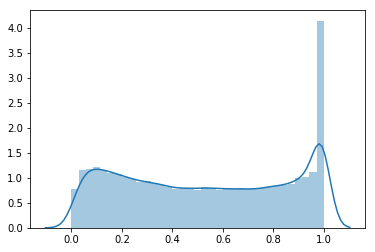

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
p =sess.run(prob, feed_dict={x: X_test})
sns.distplot(p[:,0])

In [41]:
from sklearn.metrics import confusion_matrix
y_1, y_2 = sess.run([tf.argmax(y, 1), tf.argmax(pred, 1)] , {x: X_test, y: Y_test})
confusion_matrix(y_1, y_2)

array([[ 9657,  3186],
       [28083, 31939]])

In [42]:
from sklearn.metrics import confusion_matrix
y_1, y_2 = sess.run([tf.argmax(y, 1), tf.argmax(pred, 1)] , {x: X_train, y: Y_train})
confusion_matrix(y_1, y_2)

array([[22338,  7499],
       [65425, 74754]])

In [36]:
idx1 = np.random.choice(np.arange(len(Y_test[Y_test[:,1] == 0])), 10000)
idx2 = np.random.choice(np.arange(len(Y_test[Y_test[:,1] == 1])), 10000)

y_test_1 = Y_test[Y_test[:,1] == 0][idx1]
x_test_1 = X_test[Y_test[:,1] == 0][idx1]
y_test_2 = Y_test[Y_test[:,1] == 1][idx2]
x_test_2 = X_test[Y_test[:,1] == 1][idx2]

In [37]:
np.concatenate([x_test_1, x_test_2])
np.concatenate([y_test_1, y_test_2])

array([[ 5.,  0.],
       [ 5.,  0.],
       [ 5.,  0.],
       ..., 
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.]])

In [38]:
sess.run(accuracy, feed_dict={x: np.concatenate([x_test_1, x_test_2]), y: np.concatenate([y_test_1, y_test_2])})

0.6401